## Stock Market Prediction


In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [221]:
ticker_symbol='AAPL'
data=yf.download(ticker_symbol,start='2024-07-01',end='2024-08-29',interval='2m')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-07-15 09:30:00-04:00,236.531998,236.669998,235.420197,236.229996,236.229996,4768402
2024-07-15 09:32:00-04:00,236.223007,237.229996,236.010300,236.189896,236.189896,1930843
2024-07-15 09:34:00-04:00,236.175995,236.979996,236.149994,236.210007,236.210007,1109143
2024-07-15 09:36:00-04:00,236.190002,236.560303,234.970001,235.177200,235.177200,949027
2024-07-15 09:38:00-04:00,235.172104,235.190002,234.500000,234.922501,234.922501,762876
...,...,...,...,...,...,...
2024-08-28 15:50:00-04:00,227.225006,227.399994,227.130005,227.350006,227.350006,219501
2024-08-28 15:52:00-04:00,227.350006,227.539993,227.320007,227.470001,227.470001,198071
2024-08-28 15:54:00-04:00,227.460007,227.475006,226.710007,226.764999,226.764999,415429


In [222]:
data.shape

(6433, 6)

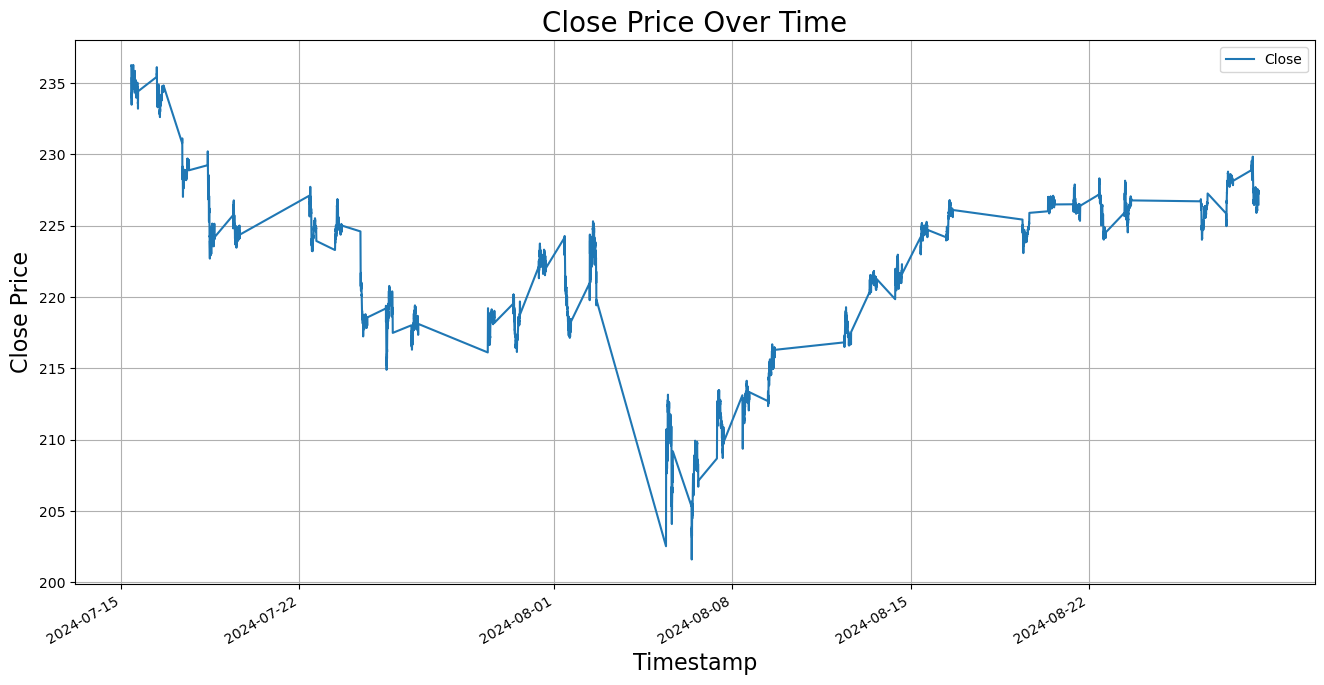

In [223]:
data.plot.line(y="Close",use_index=True, figsize=(16, 8))
plt.title('Close Price Over Time', fontsize=20)
plt.xlabel('Timestamp', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.grid(True)
plt.show()


In [224]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-07-15 09:30:00-04:00,236.531998,236.669998,235.420197,236.229996,236.229996,4768402
2024-07-15 09:32:00-04:00,236.223007,237.229996,236.010300,236.189896,236.189896,1930843
2024-07-15 09:34:00-04:00,236.175995,236.979996,236.149994,236.210007,236.210007,1109143
2024-07-15 09:36:00-04:00,236.190002,236.560303,234.970001,235.177200,235.177200,949027
2024-07-15 09:38:00-04:00,235.172104,235.190002,234.500000,234.922501,234.922501,762876


In [225]:
data[data['Close']==data['Adj Close']].shape

(6433, 6)

In [226]:
data = data.drop(['Adj Close'], axis=1, errors='ignore')

In [227]:
df=data.reset_index()['Close']

In [228]:
df

0       236.229996
1       236.189896
2       236.210007
3       235.177200
4       234.922501
           ...    
6428    227.350006
6429    227.470001
6430    226.764999
6431    226.541000
6432    226.490005
Name: Close, Length: 6433, dtype: float64

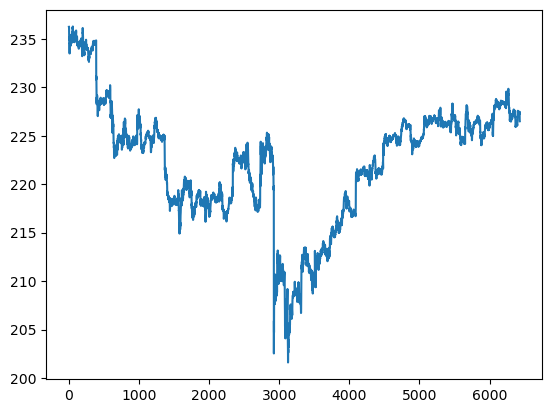

In [229]:
plt.plot(df)

In [230]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

array([[0.99899566],
       [0.99783853],
       [0.99841885],
       ...,
       [0.72587343],
       [0.71940971],
       [0.7179382 ]])

In [231]:
## splitting the dataset into twor prts training and testing data
train_size=int(len(df)*0.7)
test_size=len(df)-train_size
train_data,test_data=scaled_data[0:train_size,:],scaled_data[train_size:len(df),:1]


In [232]:
train_data.shape,test_data.shape

((4503, 1), (1930, 1))

In [233]:
def create_dataset(dataset,time_step):
    dataX, dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:i+(time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [234]:
time_step=100
X_train, Y_train=create_dataset(train_data,time_step)
X_test, Y_test=create_dataset(test_data,time_step)

In [235]:
X_train.shape,Y_test.shape

((4402, 100), (1829,))

In [236]:
#reshape input to be LSTM which is 3Dimensional
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1) 

In [237]:
model=Sequential()
model.add(LSTM(50,activation='tanh',return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)




In [238]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_15 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_16 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_16 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_17 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_18 (LSTM)              (None, 100, 50)          

In [239]:
model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/100
35/35 [==============================] - 13s 290ms/step - loss: 0.0518 - val_loss: 0.0021
Epoch 2/100
35/35 [==============================] - 9s 272ms/step - loss: 0.0064 - val_loss: 4.4835e-04
Epoch 3/100
35/35 [==============================] - 10s 277ms/step - loss: 0.0048 - val_loss: 4.1712e-04
Epoch 4/100
35/35 [==============================] - 10s 274ms/step - loss: 0.0041 - val_loss: 5.8547e-04
Epoch 5/100
35/35 [==============================] - 9s 269ms/step - loss: 0.0040 - val_loss: 4.6939e-04
Epoch 6/100
35/35 [==============================] - 9s 270ms/step - loss: 0.0041 - val_loss: 5.3465e-04
Epoch 7/100
35/35 [==============================] - 10s 276ms/step - loss: 0.0037 - val_loss: 3.2124e-04
Epoch 8/100
35/35 [==============================] - 10s 278ms/step - loss: 0.0036 - val_loss: 6.5881e-04
Epoch 9/100
35/35 [==============================] - 10s 279ms/step - loss: 0.0036 - val_loss: 3.5859e-04
Epoch 10/100
35/35 [==============================] -

In [240]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

58/58 [==============================] - 1s 21ms/step


In [241]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [242]:
math.sqrt(mean_squared_error(Y_train,train_predict))

219.53795668982178

In [243]:
math.sqrt(mean_squared_error(Y_test,test_predict))

225.21588409479315

In [244]:

Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(test_data.reshape(-1, 1))

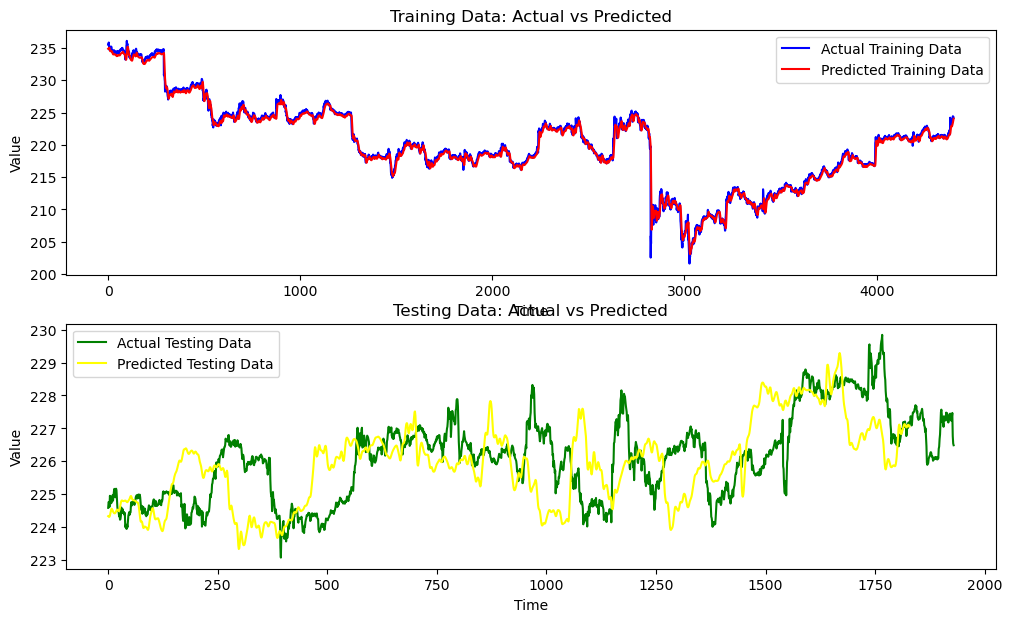

In [245]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)  # (nrows=2, ncols=1, index=1)
plt.plot(Y_train, label='Actual Training Data', color='blue')
plt.plot(train_predict, label='Predicted Training Data', color='red')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 1, 2)  # (nrows=2, ncols=1, index=2)
plt.plot(Y_test, label='Actual Testing Data', color='green')
plt.plot(test_predict, label='Predicted Testing Data', color='yellow')
plt.title('Testing Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.show()


In [246]:
model.save('StockModel.h5')

# Future 10 Days Predictions


In [247]:
fornext10days=1072
#creating a column shifted to 'x' units/days   
data['Prediction']=data[['Close']].shift(-fornext10days)
data.tail() 

,Open,High,Low,Close,Volume,Prediction
Datetime,,,,,,
2024-08-28 15:50:00-04:00,227.225006,227.399994,227.130005,227.350006,219501,NaN
2024-08-28 15:52:00-04:00,227.350006,227.539993,227.320007,227.470001,198071,NaN
2024-08-28 15:54:00-04:00,227.460007,227.475006,226.710007,226.764999,415429,NaN
2024-08-28 15:56:00-04:00,226.739899,226.860001,226.339996,226.541000,434177,NaN
2024-08-28 15:58:00-04:00,226.550003,226.611496,226.389999,226.490005,1044988,NaN


In [248]:
actual_size=int(len(data)-fornext10days)
pred_size=int(fornext10days)
actual_data=data['Prediction'][:actual_size].values.reshape(-1,1)
pred_data=data['Prediction'][actual_size:].values.reshape(-1,1),

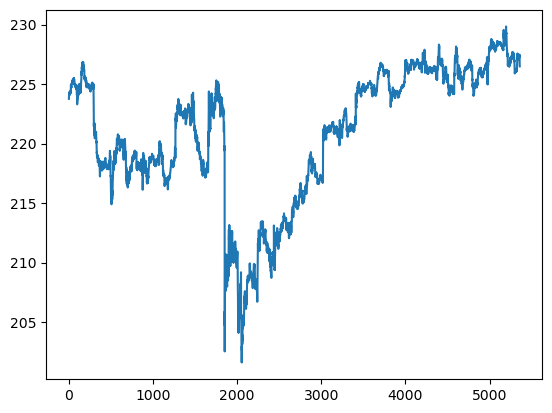

In [249]:
plt.plot(actual_data)

In [250]:
scaler = MinMaxScaler()

In [251]:
scaled_actualdata = scaler.fit_transform(np.array(actual_data).reshape(-1,1))
scaled_actualdata

array([[0.78462619],
       [0.79057728],
       [0.7913567 ],
       ...,
       [0.89107342],
       [0.88313863],
       [0.88133222]])

In [252]:
def create_dataset_10(dataset,time_step):
    dataX, dataY = [], []
    for i in range(time_step, len(dataset)):
        dataX.append(dataset[i - time_step:i, 0])
        dataY.append(dataset[i, 0])
    return np.array(dataX),np.array(dataY)

In [253]:
time_step=100
actual_x,actual_y=create_dataset_10(scaled_actualdata,time_step)

In [254]:
actual_x.shape

(5261, 100)

In [255]:
actual_x=actual_x.reshape(actual_x.shape[0],actual_x.shape[1],1)

In [256]:
# Initialize testing_data with the last 'time_step' values from the scaled dataset, reshaped to match the model input shape
testing_data = scaled_actualdata[-time_step:].reshape(1, time_step, 1)


In [267]:
testing_data.shape

(1, 100, 1)

In [268]:
future_predictions = []

In [269]:
for _ in range(1072):  # Number of future days to predict
    # Make a prediction
    pred_value = model.predict(testing_data)
    
    # Inverse scale the prediction back to original value
    pred_value_inversed = scaler.inverse_transform(pred_value)
    
    # Store the prediction
    future_predictions.append(pred_value_inversed[0, 0])
    
    # Update testing_data by appending the new prediction and dropping the first value
    new_input = np.append(testing_data[0, 1:], pred_value)
    testing_data = new_input.reshape(1, time_step, 1)

1/1 [==============================] - 0s 20ms/step


In [270]:
future_predictions = np.array(future_predictions)
future_predictions

array([206.25804, 206.25774, 206.25745, ..., 206.21793, 206.21793,
       206.21793], dtype=float32)

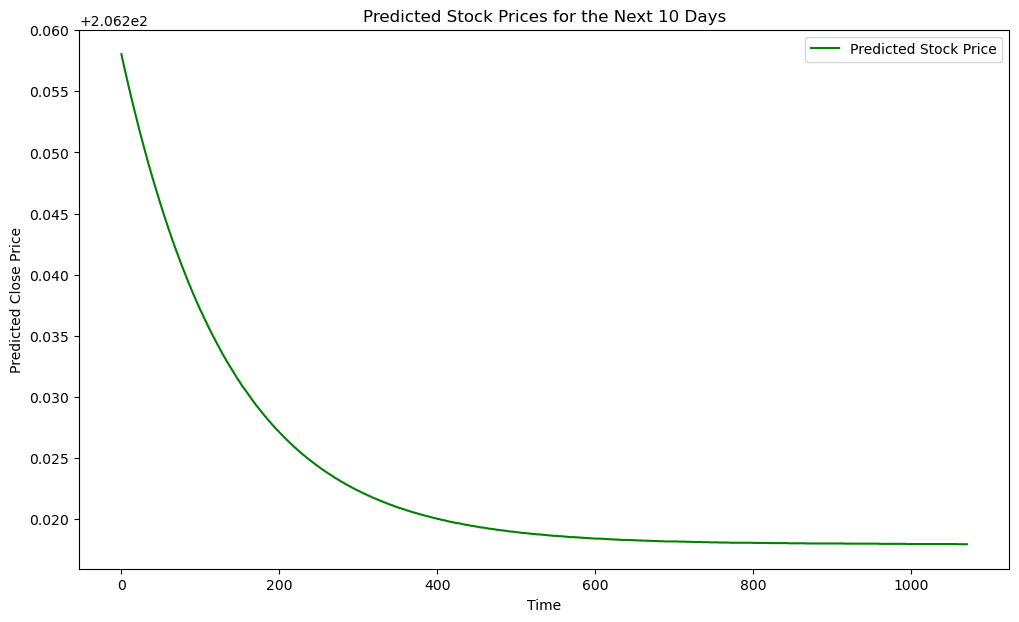

In [271]:
plt.figure(figsize=(12, 7))
plt.plot(future_predictions, label='Predicted Stock Price', color='green')
plt.title('Predicted Stock Prices for the Next 10 Days')
plt.xlabel('Time')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.show()

In [272]:
model.save('next10days.h5')